In [2]:
import os
import shutil
import matplotlib.pyplot as plt
original_dataset_dir = './img'   
classes_list = os.listdir(original_dataset_dir) 

train_dir = './img/'
classes = ["classic", "modern", "natural", "northern", "unique", "vintage"]

In [3]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames))

    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)

        


Train size( classic ):  76
Train size( modern ):  209
Train size( natural ):  138
Train size( northern ):  94
Train size( unique ):  210
Train size( vintage ):  108


In [4]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = torch.device("cpu")
BATCH_SIZE = 256 
EPOCH = 200 

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root=train_dir, transform=transform_base) 

In [6]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, 6) 
    
    def forward(self, x):  
    
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 

        return F.log_softmax(x, dim=1)  

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

In [35]:
from torchsummary import summary

summary(model_base, (3, 64, 64))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [10]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

In [11]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [12]:
import time
import copy
loss = []
acc = []
def train_baseline(model ,train_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        
        if best_acc < train_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts,f'baseline_{epoch}.pt')
            
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        loss.append(train_loss)
        acc.append(train_acc)
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(model_base, train_loader, optimizer, EPOCH)  	 #(16)


KeyboardInterrupt: 

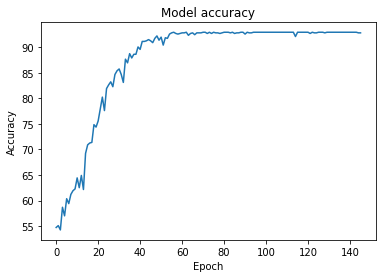

In [52]:
plt.plot(acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

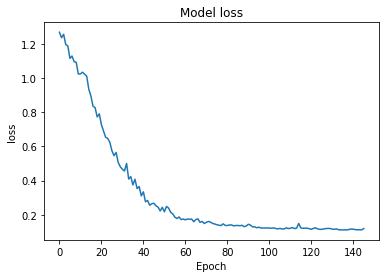

In [53]:
plt.plot(loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

Inference

In [60]:
from PIL import Image
image_name = 'images.JPG'
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
image_path = f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}"
test_base = (transform_base(Image.open(image_path))).to(DEVICE)
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

modern


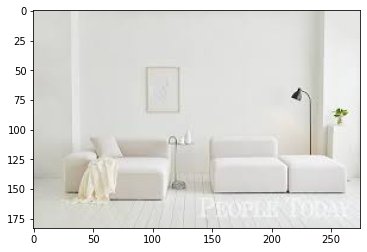

In [61]:


baseline=torch.load('D:/junyoung/4-1/AIcapstone/RoomSketcher/baseline_57.pt') 
base.load_state_dict(baseline)
base.eval()  
result = base(test_base.unsqueeze(0)).to(DEVICE)

image = plt.imread(f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}")
plt.imshow(image)
print(classes[torch.argmax(result)])
# print('baseline test acc:  ', test_accuracy)

In [14]:
base = Net().to(DEVICE)

natural


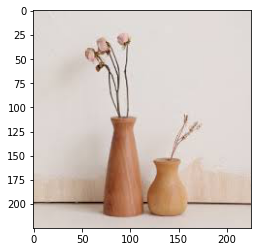

In [15]:
from PIL import Image
image_name = '22.JPG'
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
image_path = f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}"
test_base = (transform_base(Image.open(image_path))).to(DEVICE)
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



baseline=torch.load('D:/junyoung/4-1/AIcapstone/RoomSketcher/baseline_57.pt') 
base.load_state_dict(baseline)
base.eval()  
result = base(test_base.unsqueeze(0)).to(DEVICE)

image = plt.imread(f"D:/junyoung/4-1/AIcapstone/RoomSketcher/test/{image_name}")
plt.imshow(image)
print(classes[torch.argmax(result)])